# SCF optimization of a closed-shell state

The derivation of the [Kohn–Sham equation](kohn-sham-equation) follows closely the Hartree–Fock counterpart and the orbitals that minimize the DFT energy under the contraint of being orthogonal are eigenfuctions to the Kohn–Sham operator that closely resembles the [Fock operator](lagrangian) from Hartree–Fock theory. The Kohn–Sham operator takes the form

$$
\hat{f} = \hat{h} + \hat{v}_\mathrm{xc} + \sum_{j=1}^N \big( \hat{J}_j + c_{\text{x}} \hat{K}_j \big)
$$

where we note that the exchange term in the Fock operator has been at least partially replaced by the exchange–correlation potential

$$
v_\mathrm{xc}(\mathbf{r}) = \frac{\delta E_\mathrm{xc}}{\delta n(\mathbf{r})}
$$

For *pure* functionals, $c_{\text{x}} = 0$ whereas for *hybrid* functionals, we have $0 < c_{\text{x}} < 1$.

So an existing module for the [SCF optimization of a Hartree–Fock](scf-procedure) state is made capable to optimize a Kohn–Sham state by modifying the Fock operator accordingly. Let us do just that under the assumption that the exchange–correlation functional merely includes [Slater exchange](https://en.wikipedia.org/wiki/Local-density_approximation#Exchange_functional)

$$
\varepsilon_\mathrm{xc}(n(\mathbf{r})) =
-\frac{3}{4} \Big(\frac{3}{\pi}\Big)^{1/3} \big[n(\mathbf{r})\big]^{1/3}
$$

In the LDA, we have

$$
v_\mathrm{xc}(\mathbf{r}) =
\varepsilon_\mathrm{xc}(n(\mathbf{r})) + n(\mathbf{r})
\frac{\partial \varepsilon_\mathrm{xc}}{\partial n}
$$

and, in our particular case, we get

$$
v_\mathrm{xc}(\mathbf{r}) = \frac{4}{3} \varepsilon_\mathrm{xc}(n(\mathbf{r}))
$$

where

$$
n(\mathbf{r}) = 2 \times \sum_{i=1}^{N/2} \left|\phi_i(\mathbf{r})\right|^2
$$

In [1]:
import veloxchem as vlx
import numpy as np
import matplotlib.pyplot as plt

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


## Setting up the system

In [2]:
mol_str = """
O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis = vlx.MolecularBasis.read(molecule, '6-31g')

nbas = vlx.MolecularBasis.get_dimensions_of_basis(basis, molecule)
nocc = molecule.number_of_electrons() // 2
V_nuc = molecule.nuclear_repulsion_energy()

print('Number of contracted basis functions:', nbas)
print('Number of doubly occupied molecular orbitals:', nocc)
print(f'Nuclear repulsion energy (in a.u.): {V_nuc : 14.12f}')

Number of contracted basis functions: 13
Number of doubly occupied molecular orbitals: 5
Nuclear repulsion energy (in a.u.):  9.343638157670


## Reference calculation

Let us first perform an reference calculation using the restricted closed-shell SCF driver in VeloxChem.

In [3]:
scf_settings = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'slater', 'grid_level': 4}

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [4]:
print(f'Final DFT energy: {scf_drv.get_scf_energy() : 12.8f} Hartree')

Final DFT energy: -75.15058106 Hartree


In [5]:
# =============================================================
# integrals in AO basis
# =============================================================

# overlap matrix
overlap_drv = vlx.OverlapIntegralsDriver()
S = overlap_drv.compute(molecule, basis).to_numpy()

# one-electron Hamiltonian
kinetic_drv = vlx.KineticEnergyIntegralsDriver()
T = kinetic_drv.compute(molecule, basis).to_numpy()

nucpot_drv = vlx.NuclearPotentialIntegralsDriver()
V = -nucpot_drv.compute(molecule, basis).to_numpy()

h = T + V 

# two-electron Hamiltonian
eri_drv = vlx.ElectronRepulsionIntegralsDriver()
g = np.zeros((nbas, nbas, nbas, nbas))
eri_drv.compute_in_mem(molecule, basis, g)

# =============================================================
# Fock matrix diagonalization
# =============================================================

# symmetric transformation
sigma, U = np.linalg.eigh(S)
X = np.einsum('ik,k,jk->ij', U, 1/np.sqrt(sigma), U)
def get_MO_coeff(F):

    F_OAO = np.einsum('ki,kl,lj->ij', X, F, X)
    epsilon, C_OAO = np.linalg.eigh(F_OAO)    
    C = np.einsum("ik,kj->ij", X, C_OAO)
    
    return C

# =============================================================
# DIIS convergence acceleration
# =============================================================

def get_DIIS_fock(F_mats, e_vecs):
    
    n = len(e_vecs)
    
    # build DIIS matrix
    B = -np.ones((n + 1, n + 1))
    B[n, n] = 0

    for i in range(n):
        for j in range(n):
            B[i,j] = np.dot(e_vecs[i], e_vecs[j])
            
    b = np.zeros(n + 1)
    b[n] = -1
    
    w = np.matmul(np.linalg.inv(B), b)

    F_ave = np.zeros((nbas, nbas))
    evec_ave = np.zeros(nocc * (nbas - nocc))
    for i in range(n):
        F_ave += w[i] * F_mats[i]
        evec_ave += w[i] * e_vecs[i]
        
    F_mats[-1] = F_ave
    e_vecs[-1] = evec_ave
    
    return F_ave

## XC contribution to Fock matrix

The contrbutions from $\hat{v}_\mathrm{xc}$ to the Fock operator in the AO matrix representation will be obtained by means of numerical integration. 

$$
F^\mathrm{xc}_{\alpha\beta} = 
( \phi_\alpha | \hat{v}_\mathrm{xc} | \phi_\beta ) \approx
\sum_{i=1}^P
w_i \,
v_\mathrm{xc}(\mathbf{r}_i) \,
\phi_\alpha^\ast(\mathbf{r}_i)\phi_\beta(\mathbf{r}_i)
$$

We start by defining a molecular grid with grid points and weights. The number of grid points, $P$, will depend on the chosen grid level accuracy. The default level in VeloxChem is equal to 4.

In [6]:
grid_drv = vlx.veloxchemlib.GridDriver()

grid_drv.set_level(4) # default level in VeloxChem

mol_grid = grid_drv.generate(molecule)
weights = mol_grid.w_to_numpy()

In order to carry out the numerical integration, we need the values of the total density, $n(\mathbf{r}_i)$, as well as pairs of atomic orbitals, $\phi_\alpha^\ast(\mathbf{r}_i)\phi_\beta(\mathbf{r}_i)$, on the grid points. 

VeloxChem provides the class `DensityGridDriver` and the method `generate` to determine the values of densities (as represented by AO density matrices) on the grid points. This gives immediate access to $n(\mathbf{r}_i)$. 

To get hold of $\phi_\alpha^\ast(\mathbf{r}_i)\phi_\beta(\mathbf{r}_i)$, we construct an auxiliary density matrix

$$
D_{\gamma\delta} = \delta_{\gamma\alpha} \delta_{\delta\beta}
$$

and employ the same routine.

In [7]:
den_drv = vlx.veloxchemlib.DensityGridDriver()
xctype = 'LDA' # generate densities but no gradients of densities

def LDA_exchange(D):
    
    F_xc = np.zeros((nbas,nbas))

    den_array_format = np.array([D, D])
    den_cpp_format = vlx.veloxchemlib.AODensityMatrix(den_array_format, vlx.veloxchemlib.denmat.rest)
    den_grid = den_drv.generate(den_cpp_format, molecule, basis, mol_grid, xctype)
    den_alpha = den_grid.density_aa_to_numpy(0)
    den_beta  = den_grid.density_bb_to_numpy(0)
    
    n = den_alpha + den_beta # density on the molecular grid
    
    e_xc = - 0.75 * (3 / np.pi)**(1/3) * n**(1/3)
    E_xc = np.dot(weights, n * e_xc)
    
    v_xc = - (3 / np.pi)**(1/3) * n**(1/3)
        
    D = np.zeros((nbas,nbas)) # auxiliary density matrix for orbital pairs
    
    for alpha in range(nbas):
        for beta in range(alpha, nbas):

            D[alpha, beta] = 1.0

            den_array_format = np.array([D, D])
            den_cpp_format = vlx.veloxchemlib.AODensityMatrix(den_array_format, vlx.veloxchemlib.denmat.rest)
            den_grid = den_drv.generate(den_cpp_format, molecule, basis, mol_grid, xctype)
            den_ao_pair = den_grid.density_aa_to_numpy(0)

            F_xc[alpha,beta] = np.dot(weights, v_xc * den_ao_pair)
            F_xc[beta,alpha] = F_xc[alpha,beta]
        
            D[alpha, beta] = 0.0

    return F_xc, E_xc

## SCF procedure

Let us merely modify the Fock matrix in the existing module for the [SCF optimization of a Hartree–Fock](scf-procedure) state and instead converge the Kohn–Sham state. 

In [8]:
max_iter = 50
conv_thresh = 1e-5

e_vecs = []
F_mats = []

# initial guess from core Hamiltonian
C = get_MO_coeff(h)

print("iter       SCF energy   LDA exchange   Exact exchange   Error norm")

for iter in range(max_iter):
    
    D = np.einsum('ik,jk->ij', C[:, :nocc], C[:, :nocc])
        
    J = np.einsum('ijkl,kl->ij', g, D)
    F = h + 2*J      # no exact exchange in the Fock matrix
    
    F_xc, E_xc = LDA_exchange(D)
    F += F_xc        # add LDA exchange
    
    F_mats.append(F)
    
    E = np.einsum('ij,ij->', 2*h + 2*J, D) + V_nuc
    E += E_xc

    # determine exact exchange for comparison
    K = np.einsum('ilkj,kl->ij', g, D)
    E_exact_exchange = np.einsum('ij,ij->', -K, D)

    # compute convergence metric
    F_MO = np.einsum('ki,kl,lj->ij', C, F, C)
    e_vecs.append(np.reshape(F_MO[:nocc, nocc:], -1))
    error = np.linalg.norm(e_vecs[-1])

    print(f'{iter:>2d} {E:18.8f} {E_xc:14.8f} {E_exact_exchange:16.8f} {error:12.2e}')

    if error < conv_thresh:
        print('SCF iterations converged!')
        break
        
    F = get_DIIS_fock(F_mats, e_vecs)
    
    C = get_MO_coeff(F)

iter       SCF energy   LDA exchange   Exact exchange   Error norm
 0       -68.60921388   -10.70568929     -11.74379335     1.85e+00
 1       -67.48094965    -6.48294784      -7.34508108     2.00e+00
 2       -75.10007420    -8.01224248      -8.84607844     2.04e-01
 3       -75.14419461    -8.18308773      -9.01388976     9.33e-02
 4       -75.13644750    -8.00166768      -8.82683360     1.41e-01
 5       -75.14997930    -8.08515413      -8.91258142     2.95e-02
 6       -75.14726153    -8.15916365      -8.98889501     6.82e-02
 7       -75.15045621    -8.11759127      -8.94590180     1.33e-02
 8       -75.15058097    -8.10764053      -8.93564110     3.21e-04
 9       -75.15058074    -8.10796002      -8.93597181     6.74e-04
10       -75.15058074    -8.10795959      -8.93597120     6.77e-04
11       -75.15058076    -8.10794182      -8.93595286     6.54e-04
12       -75.15058106    -8.10742369      -8.93541839     2.50e-05
13       -75.15058106    -8.10746119      -8.93545694     2.35

We note that the final SCF energy equals the one above as obtained in the reference calculation. It is also seen that the LDA exchange energy is some 0.83 Hartree higher than the corresponding exact Hartree–Fock exchange energy.

## Self-interaction error

In Hartee–Fock, the exchange energy equals

$$
E_{\mathrm{x}}^\mathrm{HF} = - \sum_{i=1}^{N/2} K_{ii}
; \qquad
K_{ii} = \sum_{j=1}^{N/2}
( \phi_i \phi_j | \phi_j \phi_i )
$$

The term in $K_{ii}$ with $j = i$ cancels the self-interaction in the classical Coulomb electron repulsion energy. In DFT, with an approximate form of the exchange–correlation energy functional, this cancelation is no longer guaranteed.

In our case, the DFT exchange energy equals

$$
E_{\mathrm{x}}^\mathrm{LDA} = 2
\sum_{i=1}^{N/2} ( \phi_i | \hat{\varepsilon}_\mathrm{xc} | \phi_i ) = 
\frac{3}{2} \sum_{i=1}^{N/2} ( \phi_i | \hat{v}_\mathrm{xc} | \phi_i ) =
\frac{3}{2} \sum_{i=1}^{N/2} F^\mathrm{xc}_{ii}
$$

where the factor of 2 stems from the double occupancy of orbitals.

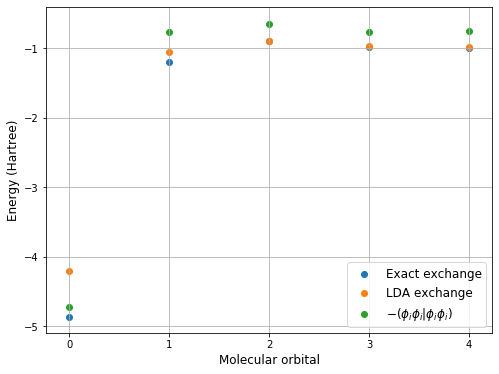

In [9]:
import matplotlib.pyplot as plt

F_xc_ii = []
K_ii = []
g_iiii = []

for i in range(nocc):

    F_xc_ii.append(np.einsum('a,b,ab->', C[:,i], C[:,i], F_xc))
    K_ii.append(np.einsum('a,b,ab->', C[:,i], C[:,i], K))
    g_iiii.append(np.einsum('a,b,c,d,abcd->', C[:,i], C[:,i], C[:,i], C[:,i], g)) 

LDA_x_ii = 1.5 * np.array(F_xc_ii)
HF_x_ii = -np.array(K_ii)
g_iiii = np.array(g_iiii)
    
fig = plt.figure(figsize = (8,6))

ax = plt.axes(xticks = range(5))

ax.scatter(range(nocc), HF_x_ii, label = 'Exact exchange')
ax.scatter(range(nocc), LDA_x_ii, label = 'LDA exchange')
ax.scatter(range(nocc), -g_iiii, label = r'$-(\phi_i\phi_i | \phi_i\phi_i)$')

ax.legend(fontsize = 12)
ax.grid(True)

plt.xlabel('Molecular orbital', fontsize = 12)
plt.ylabel('Energy (Hartree)', fontsize = 12)

plt.show()

First, we note that the self-interaction energy (SIE) in terms of the integral $(\phi_i\phi_i|\phi_i\phi_i)$ represents a dominant part of the exchange energy. The percentage contributions exceed 60% for all orbitals and it reaches 97% for the core 1s-orbital.

In [10]:
print('SIE percentage part of exchange energy')
for i in range(5):
    print(f'{i} {-g_iiii[i] / HF_x_ii[i] * 100 : 6.1f}%')

SIE percentage part of exchange energy
0   97.0%
1   64.2%
2   73.3%
3   77.5%
4   76.6%


Second, we note that the LDA exchange energy is closely equal to the exact Hartree–Fock exchange energy for the outer valence orbitals but substantially less so for the core and inner valence orbitals. For the core 1s-orbital, the two results differ by some 0.66 Hartree.

In [11]:
print('Comparison of LDA and HF exchange energies')
for i in range(5):
    print(f'{i} {LDA_x_ii[i] / HF_x_ii[i] * 100 : 6.1f}% {LDA_x_ii[i] - HF_x_ii[i] : 6.2f} a.u.')

Comparison of LDA and HF exchange energies
0   86.4%   0.66 a.u.
1   87.9%   0.14 a.u.
2   99.9%   0.00 a.u.
3   98.5%   0.01 a.u.
4   99.5%   0.01 a.u.
